In [ ]:
# Building Micrograd 
"""
Micrograd is an auto-grad engine: 
  autograd stands for automatic-gradient and implements back-propagation.

back-propagation: 
  algorithm which allow to efficiently evaluate the gradient of some kind of a loss function with
  the repect to the weights of a neural network. We can, then, iteratively tune the weights of the
  network to minimize the loss function therefore improving the accuracy of the network.

  In other words, back-propagation is the recursive application of the chain rule backwards 
  thourgh the graph operations.
"""

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# to display the plots inline
%matplotlib inline 

from engine import Value
from utils import draw_dot

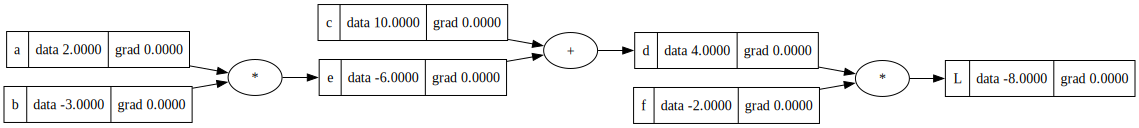

In [5]:
# EXAMPLE 1:

# build the graph
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

draw_dot(L)

In [ ]:
# dL: reads as derivate of L 
# dd: reads as derivate of d

# LOCAL DERIVATIVE COMPUTATION
# dL/dd = ? (local derivative)
"""
L = d*f
(f(x+h)-f(x))/h
((d+h)*f - d*f)/h
(d*f + h*f - d*f)/h
h*f/h
f
"""
f.grad = 4.0 # computed as local derivative of L with respect to f
d.grad = -2.0 # computed as local derivative of L with respect to d

L.grad = 1.0 # set the gradient of the output to 1.0, of course the derivate of itself is 1.0

In [ ]:
# dL/dc = ?  (CHAIN RULE DERIVATIVE COMPUTATION, 'add' operation in between)
"""
first we want to understand: 
~ dd/dc = ? ... 1.0
d = e+c
(f(x+h)-f(x))/h
((e+c)+h - (e+c))/h
(e+c+h-e-c)/h
h/h
1.0
~ symmetrically, dd/de = ? ... 1.0

this is the local derivative, we need CHAIN RULE in caluculus:
!!!
if a variable z depends on y, and y depends on x, then z depends on x through
the intermediate variable y. Chain rule is expressed as:
dz/dx = dz/dy * dy/dx
!!!
in the end, we need to multiply the local derivatives

dL/dc = (dL/dd) * (dd/dc)
dL/dc = -2.0 * 1.0
""" 
# VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
# '+' OPERATION WORKS AS A ROUTING NODE WHICH SPREADS THE GRADIENT WITHOUT AFFECTING ITS VALUE,
# since local derivative of the '+' operation is 1.0
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
c.grad = -2.0 # computed via CHAIN RULE
e.grad = -2.0 # symmetrically to c

In [ ]:
# dL/da = ?  (CHAIN RULE DERIVATIVE COMPUTATION, 'multiplication' operation in between)
"""
first we want to understand: 
~ de/da = ? ... 
e = a*b
(f(x+h)-f(x))/h
((a+h)*b - (a*b))/h
(a*b + h*b - a*b)/h
h*b/
b
-3.0

dL/da = (dL/de) * (de/da)
dL/da = -2.0 * -3.0
dL/da = 6.0
"""
# VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
# '*' OPERATION WORKS AS A SPLITTING NODE WHICH ''MULTIPLIES'' THE GRADIENT OF THE LOCAL OUTPUT
# BY THE OTHER DATA
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
a.grad = 6.0 # computed via CHAIN RULE
b.grad = -4.0 # symmetrically to a

In [ ]:
# VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
# WE KNOW HAVE SOME POWER ON THE FINAL OUTPUT OF THE NETWORK, BEING ABLE TO INFLUENCE IT 
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# we notch leaf nodes in the direction of the gradient trying to pump up/increase the L output
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# perform the forward pass
e = a*b
d = e+c
L = d*f
print(L.data) # we expect a higher value than before

-7.286496


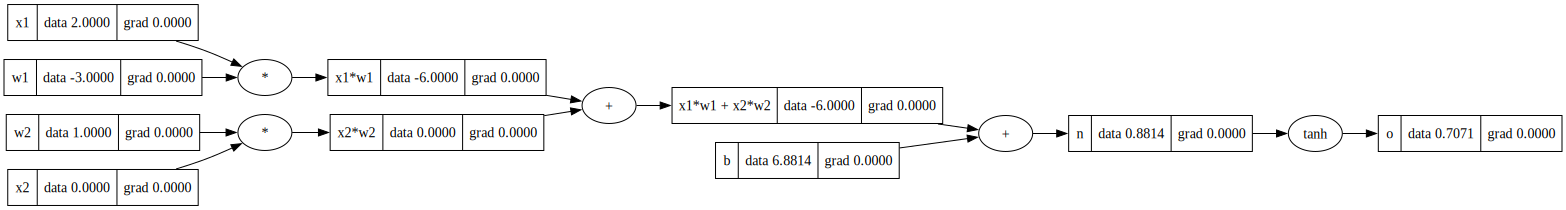

In [10]:
# MORE COMPLEX NEURONS GRAPH, 
# manual back-propagating gradients

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n= x1w1x2w2 + b; n.label = 'n'
# TANH function squashes the output between -1 and 1 at certain plateaus, regardless of the input
o = n.tanh(); o.label = 'o'

draw_dot(o)

In [ ]:
# MANUAL gradient backward propagation
o.grad = 1.0

# o = tanh(n)
# do/dn = 1 - tanh^2(n) => 1 - o^2
n.grad = 1-o.data**2

# + operation as local derivative equals to 1.0
x1w1x2w2.grad = n.grad
b.grad = n.grad

# again another + operation
x2w2.grad = x1w1x2w2.grad
x1w1.grad = x1w1x2w2.grad

# * operation 
x2.grad =  w2.data * x2w2.grad
w2.grad =  x2.data * x2w2.grad

x1.grad =  w1.data * x1w1.grad
w1.grad =  x1.data * x1w1.grad


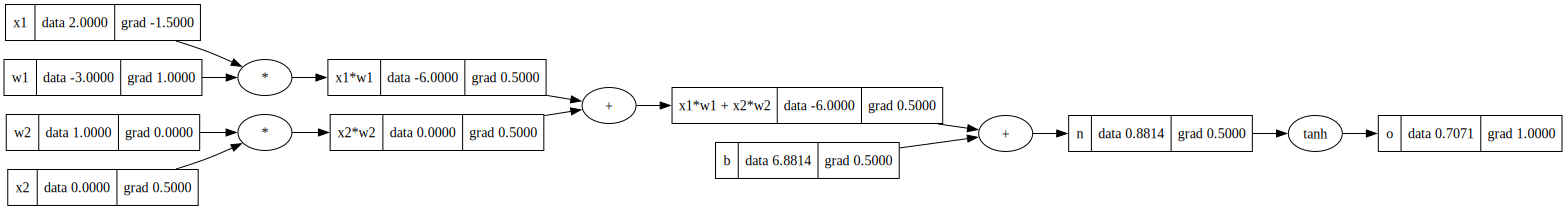

In [11]:
# AUTOMATIC gradient backward propagation on the last layer

# there is the necessity to perform backward gradient propagation only once the graph
# has computed the output. To do so, the topological sort of the graph is needed
o.backward()
draw_dot(o)

In [ ]:
# MORE COMPLEX NEURONS GRAPH PYTORCH EQUIVALENT
import torch

# casting each tensor to double to better compare with raw python 
x1 = torch.Tensor([2.0]).double(); x1.requires_grad=True # false by default for performance reasons
x2 = torch.Tensor([0.0]).double(); x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad=True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# .data.item() strips out the value from the tensor, equals to o.item() 
print(o.data.item())
o.backward()
print("-----------")
print(x1.grad.item())
print(w1.grad.item())
print(x2.grad.item())
print(w2.grad.item())

0.7071066904050358
-----------
-1.5000003851533106
1.0000002567688737
0.5000001283844369
0.0


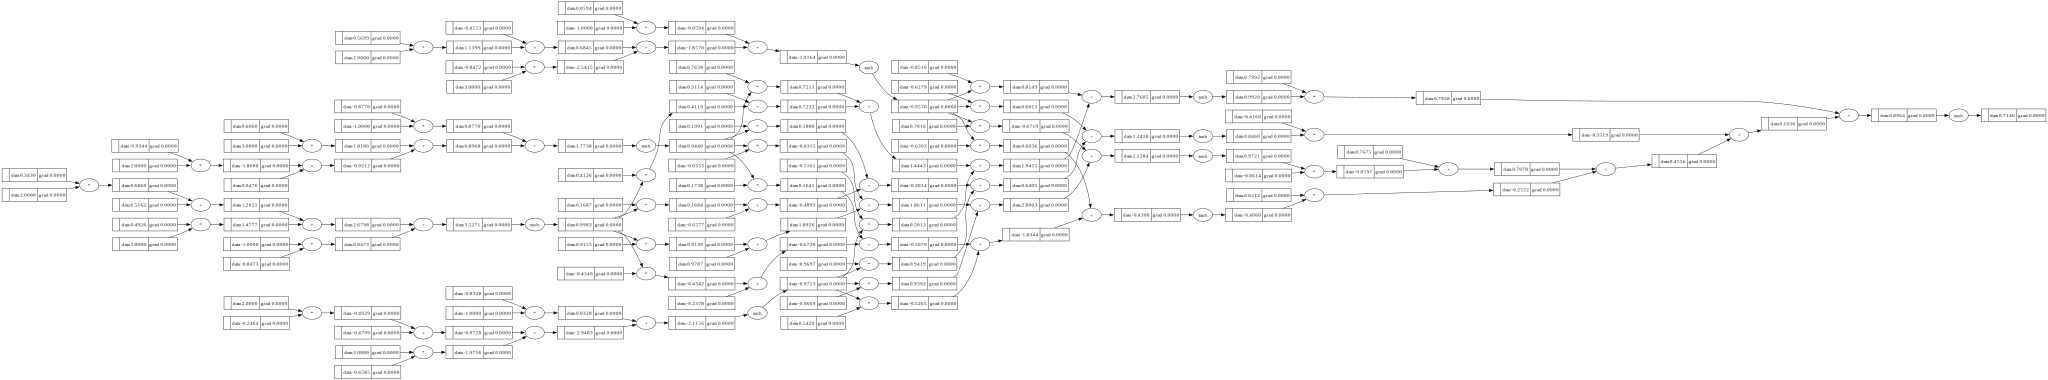

In [20]:
from nn import MLP

# three dimensional input
x = [2.0, 3.0, -1.0]
# 3 inputs into 2 layers of 4 neurons each and 1 output neuron
n = MLP(3, [4, 4, 1])

n(x)
draw_dot(n(x))

In [21]:
# MLP as a BINARY CLASSIFIER example. 

# I have 4 different inputs and I want to classify them into 2 classes
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
]
# GROUND TRUTH
# the expected output of the network for each input
ys = [
  1.0, # class 1
  -1.0, # class 2
  -1.0, # class 2
  1.0  # class 1
]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.7145519194870941),
 Value(data=-0.09711426945654722),
 Value(data=0.7348757092165451),
 Value(data=0.7835913123011412)]

In [31]:
# VVVVVVVVVVVVV
# LOSS FUNCTION
# ^^^^^^^^^^^^^

# we want a single number to somehow measure the performance of the network with re
# desired classification. This number is called !LOSS! and we want to minimize it
# so that the network can classify the inputs correctly
mse_loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
# using Mean Squared Error (MSE) as loss function you get 0 only when the output is
# exactly equal to the ground truth; otherwise you always get a positive number telling
# you how far you are from the ground truth.
mse_loss

Value(data=3.95330969562864)

In [28]:
# we want to minimize the loss function, so we need to compute the gradient of the loss
mse_loss.backward()

In [29]:
# now, thank to the back-propagation, we have the gradients of the loss function with respect to
# the weights of the network
print(n.layers[0].neurons[0].w[0].grad)
print(n.layers[0].neurons[0].w[0].data)

0.33765243391377975
0.3429804718792835


In [33]:
# VVVVVVVVVVVVVVVVVVVVV
# GRADIENT DESCENT STEP
# ^^^^^^^^^^^^^^^^^^^^^

# now, for all the parameters of the network (weights and biases) we can
# perform a !GRADIENT DESCENT STEP!, which is a way to update the weights
# and biases of the network in the direction of the gradient, so that we can minimize
# the loss function

# the STEP SIZE is NEGATIVE because we want to minimize the loss function
# and the gradient points in the direction of the increase of the loss function
# so we need to go in the opposite direction of the gradient
"""
for p in n.parameters():
  p.data += -0.01 * p.grad
"""

# so, in order to minimize the loss function, we need to iterate a gradient descent step
# FORWARD PASS (compute the loss), BACKWARD PASS, GRADIENT DESCENT STEP (update the weights and biases)
# forward pass + compute the loss
ypred = [n(x) for x in xs]
mse_loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print(mse_loss)
# backward pass
# one of the most important things to do is to ZERO the GRADIENTS before
# computing the gradients, otherwise they will accumulate
for p in n.parameters():
  p.grad = 0.0 # zero the gradients
mse_loss.backward()
# gradient descent step
for p in n.parameters():
  p.data += -0.01 * p.grad

Value(data=3.95330969562864)


In [ ]:
# TRAINING LOOP

for k in range(20):
  # forward pass + compute the loss
  ypred = [n(x) for x in xs]
  mse_loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  mse_loss.backward()
  # gradient descent step
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, mse_loss.data)

# VVVVVVVVVV
# BATCH SIZE
# ^^^^^^^^^^
# when dealing with a lot of data, we can use a BATCH SIZE to compute the loss function after 
# the forward pass and eventually the gradient descent. 
# The batch size is the number of samples we use to compute al this stuff: 
#(i.e. [n(x) for input in inputs])

0 1.6588236558999856
1 1.2493433486353094
2 0.8684662344329308
3 0.5637114028654693
4 0.3538198392136064
5 0.2252410653360708
6 0.1512843226453538
7 0.10870951118965742
8 0.08299980834036054
9 0.06646074165760048
10 0.055169090529812184
11 0.04706428148795956
12 0.041004872442574454
13 0.03632231840594921
14 0.032604571780743885
15 0.029586105995469236
16 0.027089122172602734
17 0.024990572506298145
18 0.023202842254996973
19 0.021661986758486157
